# Classify particle motion from MSD anaysis and bayesian inference (in construction)

This analysis is largely inspired from the following paper _Monnier, N. (2012). Bayesian Approach to MSD-Based Analysis of Particle Motion in Live Cells. Biophysical Journal_.

The idea is to classify particle motion in different biophysical model : diffusion, confined movement, direct, and so forth.

The input of the analysis is MSD curves of several particles (under same condition) and the output is a set of probability for different models.

For more details, the papier is available here : http://www.cell.com/biophysj/abstract/S0006-3495(12)00718-7

TODO: introduce the theory

![model](model.png)

_Monnier, N. (2012). Bayesian Approach to MSD-Based Analysis of Particle Motion in Live Cells. Biophysical Journal_

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from scipy import io

import pymc3 as pm

import matplotlib.pyplot as plt

## Load chromosomes MSD curves

Corresponds to Fig. 4 A-C in the paper.

![chromosomes](chromosomes.png)

_Monnier, N. (2012). Bayesian Approach to MSD-Based Analysis of Particle Motion in Live Cells. Biophysical Journal_

In [6]:
# Chromosomes traj
mat = io.loadmat('chromosomes.mat')
msds = mat['MSD_curves_chromosomes']
msds = pd.DataFrame(msds)
msds["delay"] = mat['timelags'].T[0]
msds.set_index("delay", drop=True, inplace=True)
msds.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
delay,,,,,,,,,,,,,,,,,,,,,
2.6,0.097573,0.373977,0.076612,0.068739,0.062353,0.036330,0.153783,0.099404,0.204890,0.292111,...,0.161717,0.132908,0.276165,0.134094,0.178738,0.175778,0.256930,0.169733,0.117894,0.262046
5.2,0.196207,0.351178,0.128585,0.123823,0.147403,0.061929,0.301612,0.227539,0.464767,0.573292,...,0.405083,0.334022,0.662523,0.338944,0.434863,0.418021,0.650792,0.432889,0.309397,0.589823
7.8,0.331055,0.470176,0.176194,0.198717,0.260169,0.092897,0.485697,0.379726,0.783481,0.893782,...,0.726817,0.593216,1.095236,0.588966,0.738894,0.725592,1.128657,0.770092,0.555813,0.947340
10.4,0.464399,0.473161,0.232980,0.281506,0.388835,0.133016,0.682776,0.554917,1.164619,1.313681,...,1.115730,0.932779,1.593391,0.893019,1.100812,1.095992,1.713535,1.185670,0.852484,1.355115
13.0,0.588834,0.479392,0.276361,0.364231,0.531622,0.175939,0.913439,0.759349,1.602612,1.764976,...,1.624899,1.348220,2.226334,1.278424,1.561110,1.566704,2.423151,1.691124,1.214357,1.832992


Display all the MSD curves

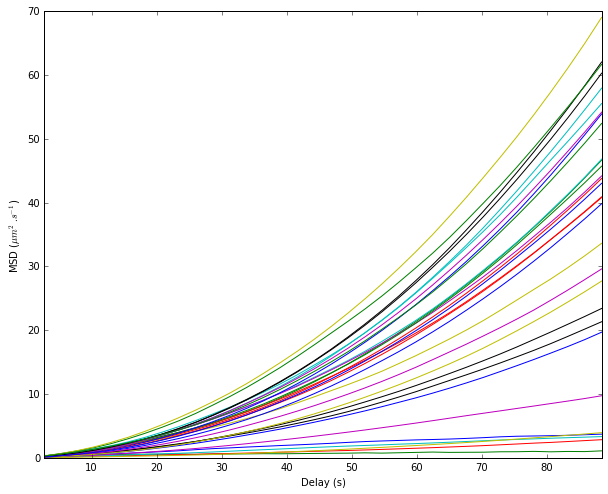

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
msds.plot(ax=ax, legend=False)

ax.set_xlabel('Delay (s)')
ax.set_ylabel('MSD ($\mu m^2.s^{-1}$)')

Display the average MSD (with std and sem)

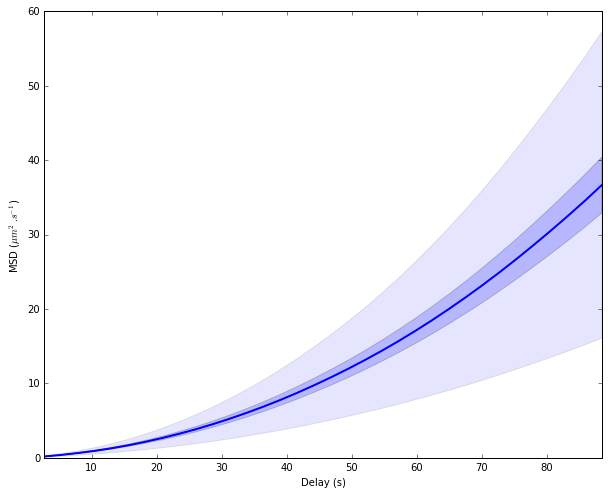

In [15]:
msd_mean = msds.mean(axis=1)
msd_std = msds.std(axis=1)
msd_sem = msds.sem(axis=1)

fig, ax = plt.subplots(figsize=(10, 8))
msd_mean.plot(ax=ax, lw=2)

# std
ax.fill_between(msd_mean.index, msd_mean, msd_mean + msd_std, alpha=0.1)
ax.fill_between(msd_mean.index, msd_mean, msd_mean - msd_std, alpha=0.1)

# sem
ax.fill_between(msd_mean.index, msd_mean, msd_mean + msd_sem, alpha=0.2)
ax.fill_between(msd_mean.index, msd_mean, msd_mean - msd_sem, alpha=0.2)

ax.set_xlabel('Delay (s)')
ax.set_ylabel('MSD ($\mu m^2.s^{-1}$)')

## Naive implementation from Matlab code

Matlab code is available here : http://msd-bayes.org/

### Covariance matrix

In `msd_curves_bayes.m`.

In [21]:
# Get the average MSD
msd_mean = msds.mean(axis=1)

# Get difference between each individual curve and the mean curve
errors = msds.copy()
for i, col in msds.iteritems():
    errors.loc[:, i] = col - msd_mean

# Calculate raw covariance matrix
error_cov_raw = np.cov(errors)

# Regularize covariance matrix (TODO)
error_cov = error_cov_raw.copy()

# Covariance of the mean curve
error_cov_raw /= errors.shape[0]
error_cov /= errors.shape[0]

Display the covariance matrix.

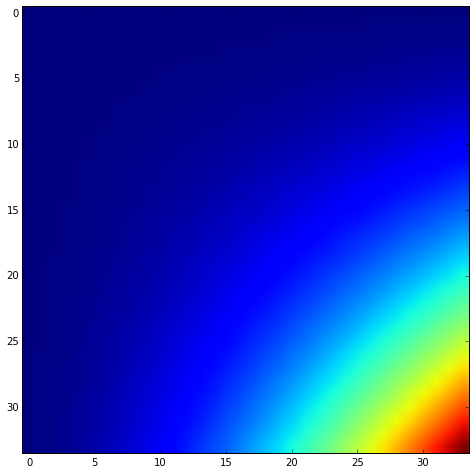

In [24]:
plt.figure(figsize=(8, 8))
plt.imshow(error_cov)

### Fitting

In `msd_fitting.m`.

In [ ]:
# TODO

## Implementation with PyMC3

See https://pymc-devs.github.io/pymc3/getting_started/#a-motivating-example-linear-regression for an introduction to PyMC3.

### Brownian diffusion

Fit the following equation : $MSD(\tau) = 4D\tau$

In [26]:
msd_mean = msds.mean(axis=1)
delay = msd_mean.index.values

with pm.Model() as model:

    # Priors for unknown model parameters
    D = pm.Uniform('D', lower=0, upper=1000)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Expected value of outcome
    msd = 4 * D * delay

    # Likelihood (sampling distribution) of observations
    #Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)
    
    y_obs = pm.Normal('y_obs', observed=msd_mean.values)

In [ ]:
with model:
    # obtain starting values via MAP
    start = pm.find_MAP()

    # instantiate sampler
    step = pm.NUTS(scaling=start)

    # draw 500 posterior samples
    trace = pm.sample(500, step, start=start)

In [ ]:
_ = pm.traceplot(trace)